## Please Note ...

The presentation is **interactive** one

**Please Click on the Arrow Button on right hand side of the cell to execute**

**Select Runtime to T4 GPU** by clicking `Runtime` --> `Change Runtime Type` --> `Hardware accelerator` to T4 GPU

## Clinical Predictive Modelling

### What is Prediction?

- **Oxford Dictionary**

> a statement that says what you think will happen

## What do we want to predict?

- Humans are notorious for trying to predict **anything**

- Clinicians want to predict the **outcome of their patients**

- **Prediction without data** $\rightarrow$ **Superstition**

- **Prediction with data** $\rightarrow$ **Supervised Machine Learning**

## Basics of Supervised Machine Learning

![](https://raw.githubusercontent.com/sumprain/ml-workshop-dataset/refs/heads/main/ml_basics.png)

## Peculiarities of Clinical Data

- Clinical data are

  - more **expensive** to collect

  - **smaller in size**

- Complex predictive models (like Deep Neural Network) **are not suitable**

- We choose model complexity based on number of events (1 degree of freedom per event)

- Undue complex models lead to **Overfitting**, which lead to **poor prediction on new patients**

## Introduction to Python and Jupyter Notebooks

[Please follow the link](https://sumprain.gitlab.io/stat-wksp-website/10-intro-python.html).

## Aim

To detect patients with low risk SLE disease, so that they can be referred to Rheumatology Centres.

## Data

Data obtained in Excel Format

## Install required libraries

In [1]:
#!pip install dtreeviz
#!pip install great_tables

## Step 1: Convert into [Comma Separated Value (CSV)](https://en.wikipedia.org/wiki/Comma-separated_values) format

## Step 2: Download data (if available in internet)

In [2]:
#!wget https://raw.githubusercontent.com/sumprain/ml-workshop-dataset/refs/heads/main/sle.csv

## Step 3: Import relevant packages in Workspace

- [Pandas](https://pandas.pydata.org/)

- [Polars](https://pola.rs/)

- [Matplotlib](https://matplotlib.org/)

- [Seaborn](https://seaborn.pydata.org/)

- [Scikit Learn](https://scikit-learn.org/stable/)

In [3]:
import polars as pl
import polars.selectors as cs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
sns.set(style = "whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibrationDisplay

import dtreeviz as dtv

from IPython.display import YouTubeVideo, display_svg

## Step 4: Load Data

In [5]:
n = pl.read_csv("sle.csv", infer_schema_length = 10000)

In [6]:
cols = "id age gender date_first_symptom date_diag date_enrol remove7 fever rash psychosis malar_rash oral_ulcer discoid_rash alopecia \
        joint_pain arthritis arthalgia gangrene photosens thrombopenia raynauds seizure lne wtloss anorexia headache palp_purpura anemia pedaledema \
        dvt subacute_cut acle aiha htn other fever_rem dur_fever wtloss_rem dur_wtloss htn_rem dur_htn lne_rem dur_lne anorexia_rem dur_anorexia \
        malar_rash_rem dur_malar_rash oral_ulcer_rem dur_oral_ulcer nasal_ulcer_rem dur_nasal_ulcer photosens_rem dur_photosens \
        discoid_rash_rem dur_discoid_rash alopecia_rem dur_alopecia subacute_cut_rem dur_subacute_cut palpable_purpura_rem dur_palpable_purpura \
        gangrene_rem dur_gangrene digital_infarct_rem dur_digital_infarct pedaledema_rem dur_pedaledema oliguria_rem dur_oliguria hematuria_rem dur_hematuria \
        chf_rem dur_chf pleuritis_pericarditis_rem dur_pleuritis_pericarditis pericardial_effusion_rem dur_pericardial_effusion \
        pleural_effusion_rem dur_pleural_effusion seizures_rem dur_seizures psychosis_rem dur_psychosis stroke_cvd_rem dur_stroke_cvd \
        aseptic_meningitis_rem dur_aseptic_meningitis headache_rem dur_headache monoarthritis_rem dur_monoarthritis oligoarthritis_rem dur_oligoarthritis \
        polyarthritis_rem dur_polyarthritis arthralgia_rem dur_arthralgia prox_muscle_weakness_rem dur_prox_muscle_weakness lne_hema_rem dur_lne_hema \
        anemia_rem dur_anemia bt_hist_rem dur_bt_hist dvt_rem dur_dvt ch_vod_rem dur_ch_vod hard_exudates_rem dur_hard_exudates \
        retinal_detach_rem dur_retinal_detach preg_loss_rem preg_loss_gt_1_rem remove0 remove1 remove2 remove3 remove4 hb tlc remove5 \
        neutrophils lymphocytes creat urine_alb cxr_overall cxr_effusion cxr_consolidation cxr_ild cxr_pe cxr_others cxr_not_done \
        sledai death remove6".split()

In [7]:
n.columns = cols

In [8]:
# (rows, cols)
n.shape

(2501, 137)

In [9]:
# selecting relevant columns
n = n.drop(cs.contains("remove"))\
     .select(pl.nth(list(range(1, 6)) + list(range(34, n.shape[1]))))

## Step 5: Identify Outcome Variable [(SLEDAI 2K Score)](https://www.mdcalc.com/calc/10099/systemic-lupus-erythematosus-disease-activity-index-2000-sledai-2k)

### Distribution of `sledai`

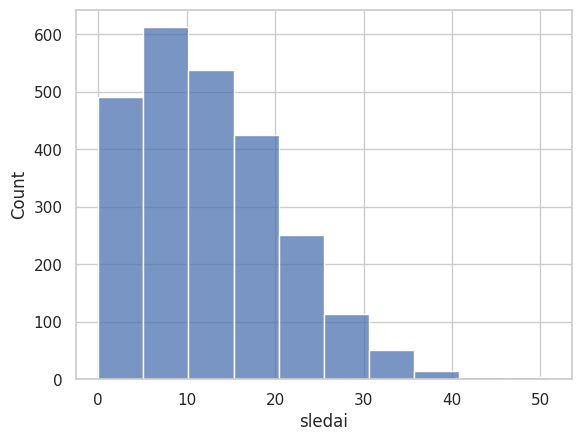

In [10]:
_ = sns.histplot(x = "sledai", data = n, binwidth=5)

In [11]:
n["sledai"].describe().style.fmt_number("value", decimals = 2)

statistic,value
count,"2,500.00"
null_count,1.00
mean,12.79
std,8.27
min,0.00
25%,7.00
50%,12.00
75%,18.00
max,51.00


## What is low risk disease?

We will decide based on the data given to us.

We have `death` and `sledai` columns.

Low Risk Disease should mean Low Mortality.

### Relation between SLEDAI and death

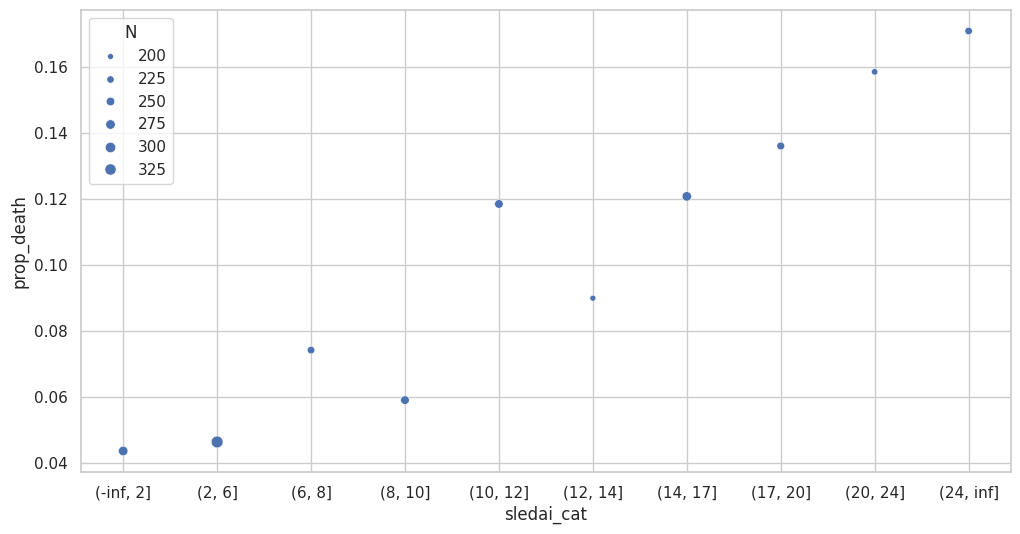

In [12]:
# Quantile cuts
f, ax = plt.subplots(figsize = (12, 6))
_ = sns.scatterplot(x = "sledai_cat", y = "prop_death", size = "N",
                data = n.with_columns(pl.col("sledai").qcut(10).alias("sledai_cat"))\
                        .group_by("sledai_cat")\
                        .agg(pl.col("death").len().alias("N"), pl.col("death").mean().alias("prop_death"))\
                        .drop_nulls()\
                        .to_pandas())

In [13]:
# Number of items with binning at SLEDAI of 10
n.select(pl.col("sledai").cut([10]).value_counts())\
 .unnest("sledai").style

sledai,count
None,1
"(-inf, 10]",1103
"(10, inf]",1397


## Step 6: Clean up Data

In [14]:
# Manipulation of the data
n = n.drop(cs.ends_with("_rem"))\
        .with_columns(cs.starts_with("dur_").as_expr().cast(pl.Int32))\
        .select(pl.all().exclude(cs.expand_selector(n, cs.starts_with("cxr_") - cs.by_name("cxr_overall"))))\
        .with_columns(pl.col("cxr_overall").fill_null(0))\
        .filter(~pl.col("sledai").is_null())\
        .select(pl.all().exclude(cs.expand_selector(n, cs.starts_with("date_") | cs.by_name("death"))))\
        .with_columns(pl.col("sledai").cut([10], labels=["1", "0"]).cast(pl.Int32).alias("sledai_cat"),\
                 (1 * (pl.col("gender") == "Female")).alias("genderF"))\
        .drop("gender")\
        .with_columns(pl.when(pl.col("tlc") > 1000).then(pl.col("tlc") / 1000).otherwise(pl.col("tlc")),\
                      pl.when(pl.col("neutrophils") > 100).then(pl.col("neutrophils") / 10).otherwise(pl.col("neutrophils")),
                      pl.when(pl.col("creat") > 10).then(pl.col("creat").mean()).otherwise(pl.col("creat")))

## Step 7: Creating Feature DataFrame and Outcome (Target) Vector

In [15]:
# Extracting explanatory variables and outcome variable
# Outcome of interest: SLEDAI <= 10, will be depicted as 1

X = n.drop(["sledai", "sledai_cat"]).to_pandas()
y = n.select(pl.col("sledai_cat")).to_pandas().to_numpy().ravel()

# MODEL BUILDING

## Step 8: Splitting the data into training dataset and test dataset

**Test dataset is not supposed to be used in training of the model**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=100)

In [17]:
# Proportion of y_train = 1
y_train.mean()

np.float64(0.441)

In [18]:
# Explanatory variables

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 301 to 1544
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         2000 non-null   int64  
 1   dur_fever                   1932 non-null   float64
 2   dur_wtloss                  1930 non-null   float64
 3   dur_htn                     2000 non-null   int32  
 4   dur_lne                     2000 non-null   int32  
 5   dur_anorexia                1933 non-null   float64
 6   dur_malar_rash              1973 non-null   float64
 7   dur_oral_ulcer              1973 non-null   float64
 8   dur_nasal_ulcer             1973 non-null   float64
 9   dur_photosens               1973 non-null   float64
 10  dur_discoid_rash            1973 non-null   float64
 11  dur_alopecia                1973 non-null   float64
 12  dur_subacute_cut            1973 non-null   float64
 13  dur_palpable_purpura        1973 non

## Step 9: Checking for and [Imputing Missing Data](https://scikit-learn.org/1.5/modules/impute.html)

In [ ]:
# Checking for Missing Values

X_train.isnull().sum(axis = 0).sort_values(ascending = False)

,0
dur_ch_vod,257
dur_hard_exudates,257
dur_retinal_detach,257
dur_psychosis,230
dur_seizures,230
dur_stroke_cvd,230
dur_aseptic_meningitis,230
dur_headache,230
dur_pleural_effusion,209
dur_pericardial_effusion,209


### Imputation

In [19]:
imp_full = SimpleImputer(strategy = "median")

In [20]:
X_train = pd.DataFrame(imp_full.fit_transform(X_train), columns=X_train.columns)

In [21]:
X_test = pd.DataFrame(imp_full.transform(X_test), columns=X_test.columns)

## Step 10: Deciding on the Predictive Model (Random Forest Classifier)

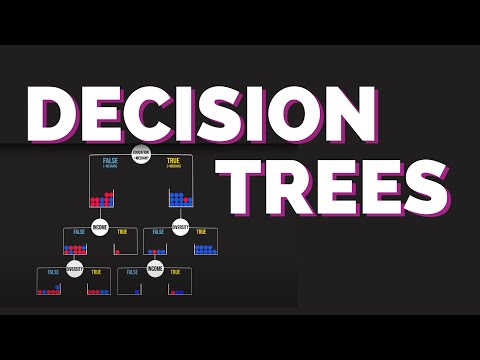

In [22]:
YouTubeVideo("zs6yHVtxyv8")

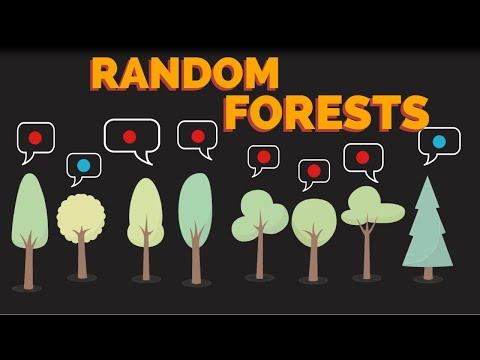

In [23]:
YouTubeVideo("cIbj0WuK41w")

## Step 11: Hyperparameter tuning to find out best performing Model

_This part is commented out, as it takes more than 5 min to run following cells_

In [24]:
param_grid_full = {"n_estimators": [10, 30, 60, 100, 300, 600, 800, 1000],
                   "max_depth": [3, 6, 9, 12, 15, None]}

In [25]:
# Hyperparameter tuning to find out best set of Hyperparameters

mod_full = GridSearchCV(estimator = RandomForestClassifier(random_state = 100),
                        scoring="roc_auc",
                        param_grid=param_grid_full,
                        return_train_score=True,
                        n_jobs = -1)

In [26]:
mod_full.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=100), n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12, 15, None],
                         'n_estimators': [10, 30, 60, 100, 300, 600, 800,
                                          1000]},
             return_train_score=True, scoring='roc_auc')

In [27]:
# Converting the result into dataframe

df_cv_results_full = pd.concat([pd.DataFrame(mod_full.cv_results_["params"]), pd.Series(mod_full.cv_results_["mean_train_score"], name = "mean_train_score"), \
           pd.Series(mod_full.cv_results_["mean_test_score"], name = "mean_test_score")], axis = "columns").fillna(20)

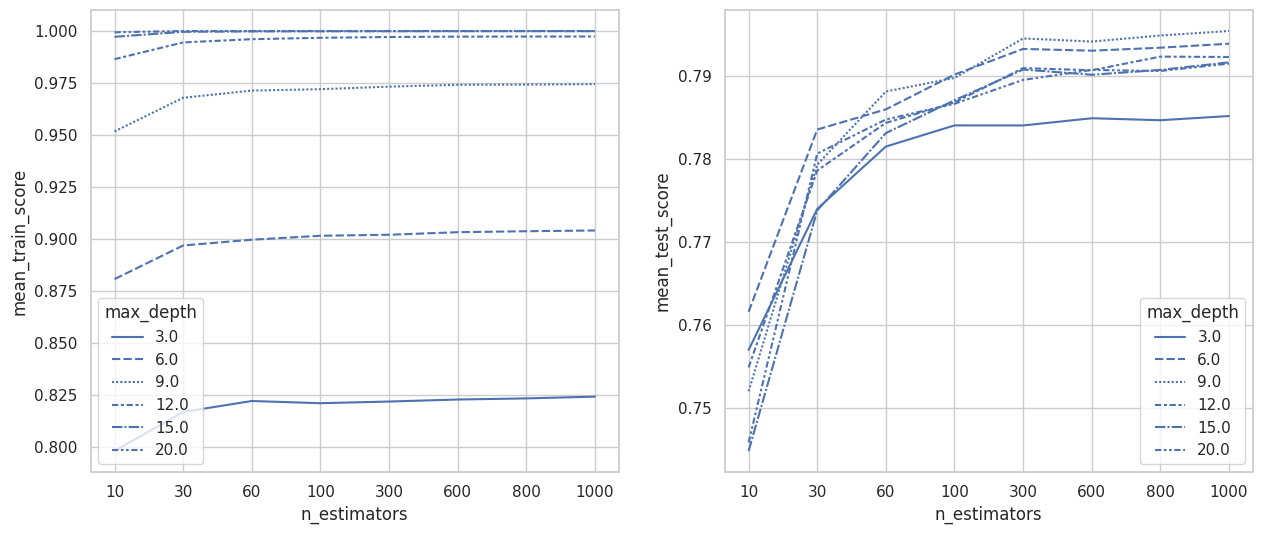

In [29]:
f, ax = plt.subplots(1, 2, figsize = (15, 6))
sns.lineplot(data = df_cv_results_full.assign(n_estimators = df_cv_results_full.n_estimators.astype(str), max_depth = df_cv_results_full.max_depth.astype(str)), \
            x = "n_estimators", y = "mean_train_score", style = "max_depth", ax = ax[0])
_ = sns.lineplot(data = df_cv_results_full.assign(n_estimators = df_cv_results_full.n_estimators.astype(str), max_depth = df_cv_results_full.max_depth.astype(str)), \
            x = "n_estimators", y = "mean_test_score", style = "max_depth", ax = ax[1])

## Step 12: Training Best Model

In [30]:
# Best Full Model

final_mod_full = mod_full.best_estimator_
#final_mod_full = RandomForestClassifier(max_depth = 9, n_estimators = 1000, random_state = 100).fit(X_train, y_train)

### Feature Importance

In [31]:
pl.DataFrame({"variable": final_mod_full.feature_names_in_, "importance": final_mod_full.feature_importances_})\
            .with_columns(pl.col("importance") / pl.col("importance").max()).sort("importance", descending = True).style.fmt_number(columns = "importance", decimals = 3)

variable,importance
urine_alb,1.000
hb,0.596
neutrophils,0.441
creat,0.425
tlc,0.371
lymphocytes,0.297
dur_oral_ulcer,0.261
age,0.241
dur_polyarthritis,0.207
dur_alopecia,0.187


### **Calibration Curve:** Pedicted probability of having low risk disease vs proportion of low risk disease patients

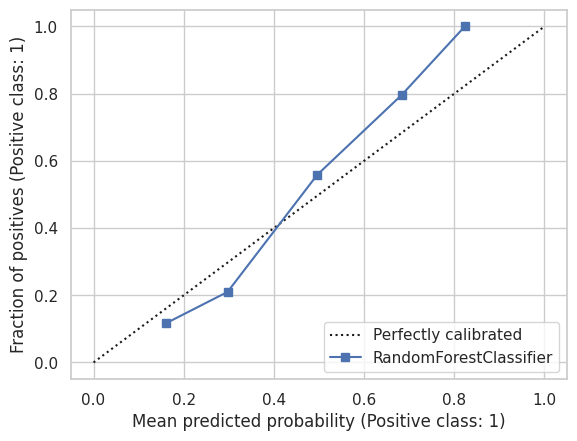

In [32]:
_ = CalibrationDisplay.from_estimator(final_mod_full, X_test, y_test)

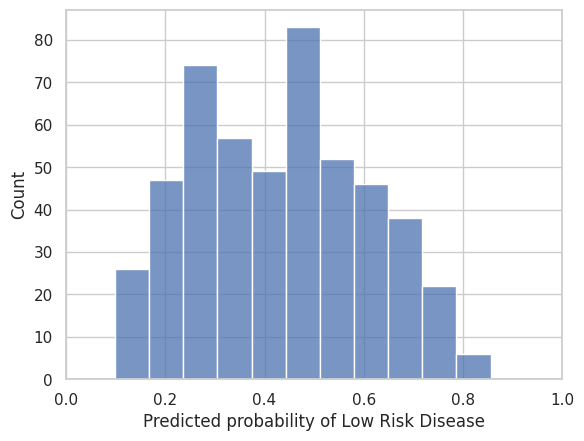

In [43]:
sns.histplot(final_mod_full.predict_proba(X_test)[:, 1])
plt.xlim(0, 1)
_ = plt.xlabel("Predicted probability of Low Risk Disease")

### **Discriminative Power:** Probability that the model correctly discriminates low risk disease from high risk disease (Concordance Index)

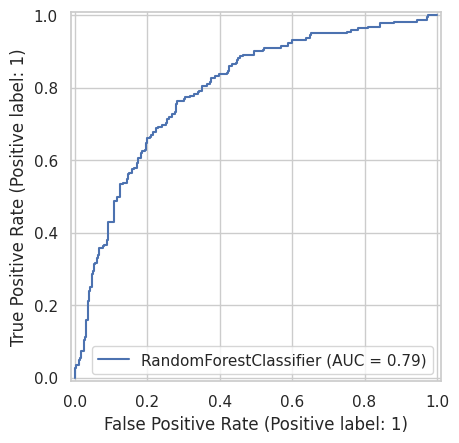

In [44]:
_ = RocCurveDisplay.from_estimator(final_mod_full, X_test, y_test)

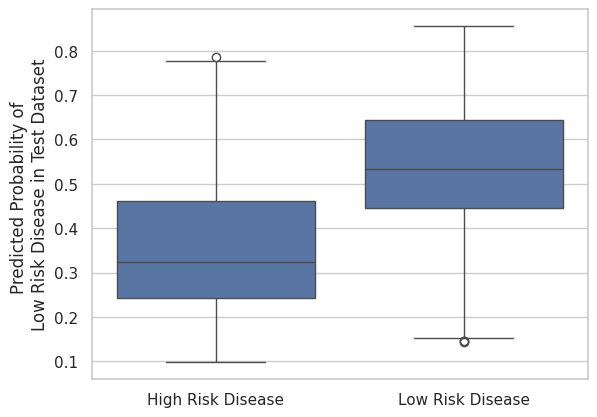

In [53]:
sns.boxplot(x = y_test, y = final_mod_full.predict_proba(X_test)[:, 1])
plt.ylabel("Predicted Probability of \nLow Risk Disease in Test Dataset")
_ = plt.xticks((0, 1), ["High Risk Disease", "Low Risk Disease"])

### **Confusion Matrix:** Displays Predicted Labels and Real Labels in a Tablular Fashion

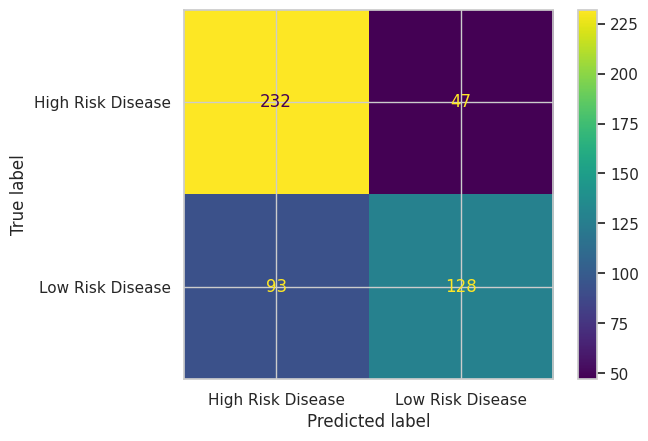

In [54]:
cm_full = confusion_matrix(y_true = y_test, y_pred = final_mod_full.predict(X_test))

_ = ConfusionMatrixDisplay(cm_full, display_labels = ["High Risk Disease", "Low Risk Disease"]).plot()

In [55]:
# Total number of variables
final_mod_full.feature_names_in_.__len__(), final_mod_full.feature_names_in_

(48,
 array(['age', 'dur_fever', 'dur_wtloss', 'dur_htn', 'dur_lne',
        'dur_anorexia', 'dur_malar_rash', 'dur_oral_ulcer',
        'dur_nasal_ulcer', 'dur_photosens', 'dur_discoid_rash',
        'dur_alopecia', 'dur_subacute_cut', 'dur_palpable_purpura',
        'dur_gangrene', 'dur_digital_infarct', 'dur_pedaledema',
        'dur_oliguria', 'dur_hematuria', 'dur_chf',
        'dur_pleuritis_pericarditis', 'dur_pericardial_effusion',
        'dur_pleural_effusion', 'dur_seizures', 'dur_psychosis',
        'dur_stroke_cvd', 'dur_aseptic_meningitis', 'dur_headache',
        'dur_monoarthritis', 'dur_oligoarthritis', 'dur_polyarthritis',
        'dur_arthralgia', 'dur_prox_muscle_weakness', 'dur_lne_hema',
        'dur_anemia', 'dur_bt_hist', 'dur_dvt', 'dur_ch_vod',
        'dur_hard_exudates', 'dur_retinal_detach', 'hb', 'tlc',
        'neutrophils', 'lymphocytes', 'creat', 'urine_alb', 'cxr_overall',
        'genderF'], dtype=object))

#### The model is good one, but there are too many features, which the user has to input to get the predicted probability of Low Risk Disease

## Step 13: Truncate the Model (Reduced Model)

Model with lesser, more manageable number of features

We will keep top 18 features with decreasing Feature Importance

In [56]:
# We will keep top 18 variables with decreasing feature importance

vars_to_be_kept = pl.DataFrame({"variable": final_mod_full.feature_names_in_, "importance": final_mod_full.feature_importances_})\
            .with_columns(pl.col("importance") / pl.col("importance").max()).sort("importance", descending = True).top_k(k = 18, by = "importance")\
            .select("variable").to_numpy().ravel()

In [57]:
n_small = n.select(cs.by_name(vars_to_be_kept), "sledai", "sledai_cat")

In [58]:
n_small

urine_alb,hb,neutrophils,creat,tlc,lymphocytes,dur_oral_ulcer,age,dur_polyarthritis,dur_alopecia,dur_malar_rash,dur_pedaledema,dur_wtloss,dur_fever,dur_subacute_cut,dur_anemia,dur_anorexia,dur_photosens,sledai,sledai_cat
i64,f64,f64,f64,f64,f64,i32,i64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i64,i32
1,11.4,34.0,0.4,4.55,62.0,5,43,0,5,0,0,0,5,0,0,0,5,3,1
0,11.5,68.0,0.6,2.93,25.0,7,38,8,10,7,0,0,8,0,0,0,10,2,1
1,9.6,49.0,0.7,5.1,38.0,0,16,4,4,0,4,4,4,0,4,4,0,7,1
0,9.6,42.0,0.5,10.8,36.0,9,21,12,12,0,0,0,10,0,0,0,12,4,1
1,10.7,58.0,0.86,4.7,35.0,6,33,0,16,6,0,0,12,0,0,0,6,2,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2,8.55,76.0,1.3,14.3,14.0,0,21,24,24,24,24,0,3,0,0,0,0,16,0
0,6.5,74.0,0.69,7.6,24.0,12,26,24,12,12,0,0,12,0,12,0,0,5,1
2,7.0,80.0,0.59,3.7,19.0,0,26,13,13,0,0,0,0,0,0,0,0,18,0


In [59]:
Xs = n_small.drop(["sledai", "sledai_cat"]).to_pandas()
ys = n_small.select(pl.col("sledai_cat")).to_pandas().to_numpy().ravel()

In [60]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size = 0.2, random_state=100)

In [61]:
ys_train.mean()

np.float64(0.441)

In [62]:
Xs_train.isnull().sum(axis = 0)

urine_alb              0
hb                     3
neutrophils           89
creat                 19
tlc                   10
lymphocytes           89
dur_oral_ulcer        27
age                    0
dur_polyarthritis     52
dur_alopecia          27
dur_malar_rash        27
dur_pedaledema       150
dur_wtloss            70
dur_fever             68
dur_subacute_cut      27
dur_anemia            93
dur_anorexia          67
dur_photosens         27
dtype: int64

In [63]:
imp_small = SimpleImputer(strategy = "median")

In [64]:
Xs_train = pd.DataFrame(imp_small.fit_transform(Xs_train), columns=Xs_train.columns)

In [65]:
Xs_test = pd.DataFrame(imp_small.transform(Xs_test), columns = Xs_test.columns)

In [66]:
param_grid_small = {"n_estimators": [10, 30, 60, 100, 300, 600, 800, 1000],
                   "max_depth": [3, 6, 9, 12, 15, None]}

In [67]:
mod_small = GridSearchCV(estimator = RandomForestClassifier(random_state = 100), scoring="roc_auc", param_grid=param_grid_small, return_train_score=True, n_jobs = -1)

In [68]:
mod_small.fit(Xs_train, ys_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=100), n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 12, 15, None],
                         'n_estimators': [10, 30, 60, 100, 300, 600, 800,
                                          1000]},
             return_train_score=True, scoring='roc_auc')

In [69]:
df_cv_results_small = pd.concat([pd.DataFrame(mod_small.cv_results_["params"]), pd.Series(mod_small.cv_results_["mean_train_score"], name = "mean_train_score"), \
           pd.Series(mod_small.cv_results_["mean_test_score"], name = "mean_test_score")], axis = "columns").fillna(20)

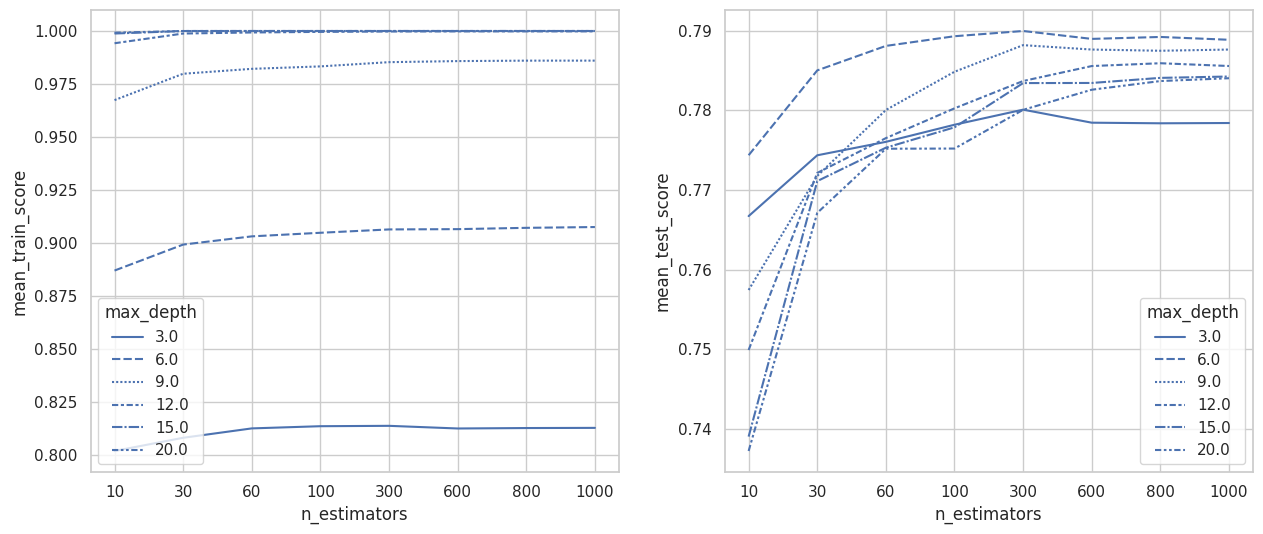

In [70]:
f, ax = plt.subplots(1, 2, figsize = (15, 6))
sns.lineplot(data = df_cv_results_small.assign(n_estimators = df_cv_results_small.n_estimators.astype(str), max_depth = df_cv_results_small.max_depth.astype(str)), \
            x = "n_estimators", y = "mean_train_score", style = "max_depth", ax = ax[0])
_ = sns.lineplot(data = df_cv_results_small.assign(n_estimators = df_cv_results_small.n_estimators.astype(str), max_depth = df_cv_results_small.max_depth.astype(str)), \
            x = "n_estimators", y = "mean_test_score", style = "max_depth", ax = ax[1])

In [71]:
final_mod_small = mod_small.best_estimator_
#final_mod_small = RandomForestClassifier(max_depth = 6, n_estimators = 300, random_state = 100).fit(Xs_train, ys_train)

In [72]:
pl.DataFrame({"variable": final_mod_small.feature_names_in_, "importance": final_mod_small.feature_importances_})\
            .with_columns(pl.col("importance") / pl.col("importance").max()).sort("importance", descending = True).style.fmt_number(columns = "importance", decimals = 3)

variable,importance
urine_alb,1.000
hb,0.492
neutrophils,0.348
creat,0.297
tlc,0.261
dur_oral_ulcer,0.195
lymphocytes,0.187
age,0.139
dur_pedaledema,0.135
dur_malar_rash,0.124


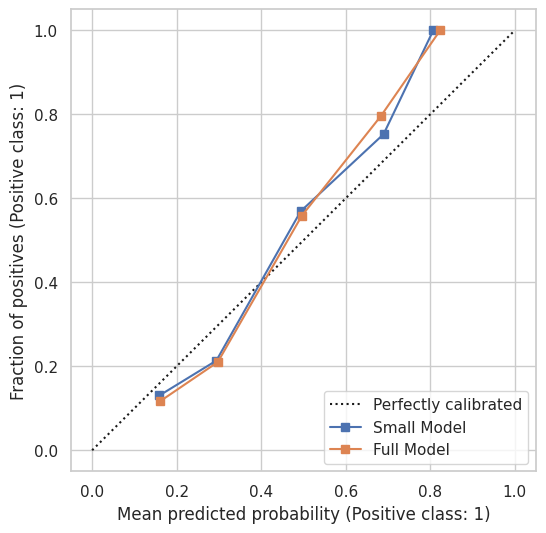

In [73]:
f, ax = plt.subplots(figsize = (6,6))
CalibrationDisplay.from_estimator(final_mod_small, Xs_test, ys_test, label = "Small Model", ax = ax)
_ = CalibrationDisplay.from_estimator(final_mod_full, X_test, y_test, label = "Full Model", ax = ax)

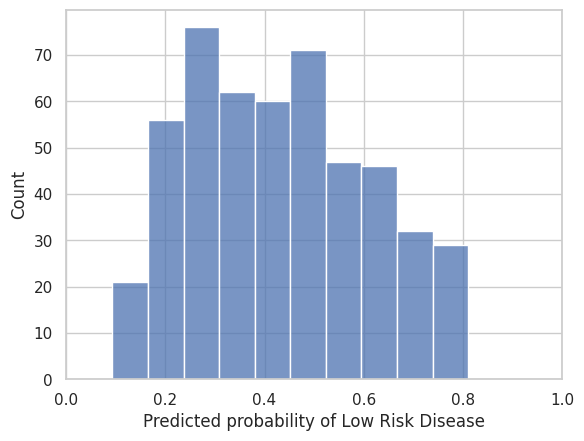

In [76]:
sns.histplot(final_mod_small.predict_proba(Xs_test)[:, 1])
plt.xlim(0, 1)
_ = plt.xlabel("Predicted probability of Low Risk Disease")

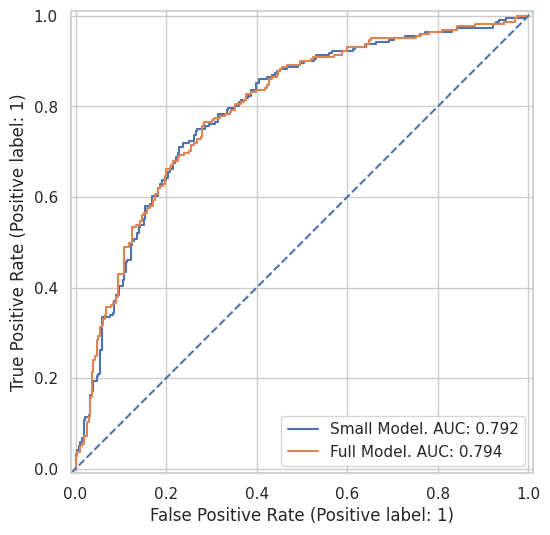

In [77]:
f, ax = plt.subplots(figsize = (6,6))
RocCurveDisplay.from_estimator(final_mod_small, Xs_test, ys_test, ax = ax,
                               label = f"Small Model. AUC: {roc_auc_score(y_true = ys_test, y_score=final_mod_small.predict_proba(Xs_test)[:, 1]):.3f}")
RocCurveDisplay.from_estimator(final_mod_full, X_test, y_test, ax = ax,
                               label = f"Full Model. AUC: {roc_auc_score(y_true = y_test, y_score=final_mod_full.predict_proba(X_test)[:, 1]):.3f}")
_ = ax.axline((0, 0), (1, 1), linestyle = "dashed")

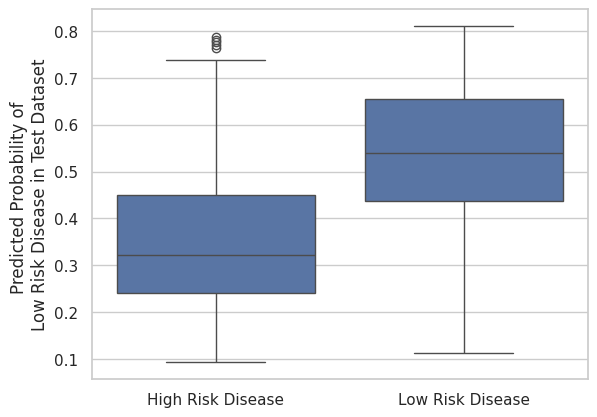

In [78]:
sns.boxplot(x = ys_test, y = final_mod_small.predict_proba(Xs_test)[:, 1])
plt.ylabel("Predicted Probability of \nLow Risk Disease in Test Dataset")
_ = plt.xticks((0, 1), ["High Risk Disease", "Low Risk Disease"])

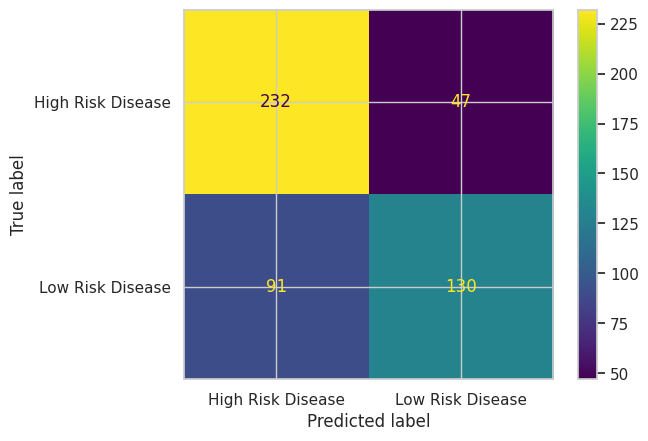

In [79]:
cm_small = confusion_matrix(y_true = ys_test, y_pred = final_mod_small.predict(Xs_test))

_ = ConfusionMatrixDisplay(cm_small, display_labels = ["High Risk Disease", "Low Risk Disease"]).plot()

## Step 14: Model Visualisation

In [80]:
@widgets.interact(idx = widgets.BoundedIntText(min = 0, max = len(final_mod_small.estimators_) - 1, description = "Decision Tree Number: "),
                 max_depth = widgets.IntSlider(min = 0, max = final_mod_small.max_depth, value = final_mod_small.max_depth))
def f_mod_vis (idx, max_depth):
    mod_vis = dtv.model(model = final_mod_small.estimators_[idx],
          X_train = Xs_train,
          y_train = ys_train,
          feature_names = Xs_train.columns,
          target_name = "disease",
          class_names = {0: "high risk", 1: "low risk"})
    display_svg(mod_vis.view(fontname = "monospace", scale = 1.2, orientation = "LR", depth_range_to_display = (0, max_depth)))

interactive(children=(BoundedIntText(value=0, description='Decision Tree Number: ', max=299), IntSlider(value=…

## **Recap ...**

![](https://raw.githubusercontent.com/sumprain/ml-workshop-dataset/refs/heads/main/ml_basics.png)

## Step 15: **Publising Model as App** to predict new patient

In [81]:
final_mod_small.feature_names_in_

array(['urine_alb', 'hb', 'neutrophils', 'creat', 'tlc', 'lymphocytes',
       'dur_oral_ulcer', 'age', 'dur_polyarthritis', 'dur_alopecia',
       'dur_malar_rash', 'dur_pedaledema', 'dur_wtloss', 'dur_fever',
       'dur_subacute_cut', 'dur_anemia', 'dur_anorexia', 'dur_photosens'],
      dtype=object)

In [82]:
@widgets.interact(urine_alb = widgets.BoundedFloatText(min = X_train.urine_alb.min(), max = X_train.urine_alb.max()),
                  neutrophils = widgets.BoundedFloatText(min = X_train.neutrophils.min(), max = X_train.neutrophils.max()),
                  hb = widgets.BoundedFloatText(min = X_train.hb.min(), max = X_train.hb.max()),
                  creat = widgets.BoundedFloatText(min = X_train.creat.min(), max = X_train.creat.max()),
                  tlc = widgets.BoundedFloatText(min = X_train.tlc.min(), max = X_train.tlc.max()),
                  lymphocytes = widgets.BoundedFloatText(min = X_train.lymphocytes.min(), max = X_train.lymphocytes.max()),
                  dur_oral_ulcer = widgets.BoundedFloatText(min = X_train.dur_oral_ulcer.min(), max = X_train.dur_oral_ulcer.max()),
                  age = widgets.BoundedFloatText(min = X_train.age.min(), max = X_train.age.max()),
                  dur_polyarthritis = widgets.BoundedFloatText(min = X_train.dur_polyarthritis.min(), max = X_train.dur_polyarthritis.max()),
                  dur_alopecia = widgets.BoundedFloatText(min = X_train.dur_alopecia.min(), max = X_train.dur_alopecia.max()),
                  dur_malar_rash = widgets.BoundedFloatText(min = X_train.dur_malar_rash.min(), max = X_train.dur_malar_rash.max()),
                  dur_pedaledema = widgets.BoundedFloatText(min = X_train.dur_pedaledema.min(), max = X_train.dur_pedaledema.max()),
                  dur_wtloss = widgets.BoundedFloatText(min = X_train.dur_wtloss.min(), max = X_train.dur_wtloss.max()),
                  dur_fever = widgets.BoundedFloatText(min = X_train.dur_fever.min(), max = X_train.dur_fever.max()),
                  dur_subacute_cut = widgets.BoundedFloatText(min = X_train.dur_subacute_cut.min(), max = X_train.dur_subacute_cut.max()),
                  dur_anemia = widgets.BoundedFloatText(min = X_train.dur_anemia.min(), max = X_train.dur_anemia.max()),
                  dur_anorexia = widgets.BoundedFloatText(min = X_train.dur_anorexia.min(), max = X_train.dur_anorexia.max()),
                  dur_photosens = widgets.BoundedFloatText(min = X_train.dur_photosens.min(), max = X_train.dur_photosens.max()),
                  lower_thres_prob = widgets.FloatSlider(min = 0, max = 1, value = 0.5))
def pred_model_small(age, hb, tlc, neutrophils, lymphocytes, creat, urine_alb, dur_oral_ulcer, dur_polyarthritis, dur_alopecia,
                    dur_malar_rash, dur_pedaledema, dur_wtloss, dur_fever, dur_subacute_cut, dur_anemia, dur_anorexia, dur_photosens,
                    lower_thres_prob):
    X_new = pd.DataFrame(dict(
        urine_alb = urine_alb,
        hb = hb,
        neutrophils = neutrophils,
        creat = creat,
        tlc = tlc,
        lymphocytes = lymphocytes,
        dur_oral_ulcer = dur_oral_ulcer,
        age = age,
        dur_polyarthritis = dur_polyarthritis,
        dur_alopecia = dur_alopecia,
        dur_malar_rash = dur_malar_rash,
        dur_pedaledema = dur_pedaledema,
        dur_wtloss = dur_wtloss,
        dur_fever = dur_fever,
        dur_subacute_cut = dur_subacute_cut,
        dur_anemia = dur_anemia,
        dur_anorexia = dur_anorexia,
        dur_photosens = dur_photosens
    ), index = [0], columns = Xs_train.columns)

    X_new = pd.DataFrame(imp_small.transform(X_new), columns = Xs_train.columns)

    pred_proba = final_mod_small.predict_proba(X_new)

    if pred_proba[0][1] < lower_thres_prob:
        pred_class = "High Risk Disease"
    else:
        pred_class = "Low Risk Disease"

    return f"Predicted Probability of Low Risk Disease: {pred_proba[0][1]:.3f}      Predicted Class: {pred_class}"


interactive(children=(BoundedFloatText(value=3.0, description='age', max=73.0, min=3.0), BoundedFloatText(valu…